In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import tempfile
os.environ['MPLCONFIGDIR'] = tempfile.mkdtemp()
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optparse, json, argparse, math
import ROOT
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
from os import environ
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Reshape,Conv2D,MaxPooling2D,ConvLSTM2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from root_numpy import root2array, tree2array

import Config as Conf 
seed = 7
##small changes
np.random.seed(7)
rng = np.random.RandomState(31337)
timestr=time.strftime("%Y%m%d-%H%M%S")
def load_data(inputPath,variables,criteria,keysf,sampleNamesf,fileNamesf,targetf):
    # Load dataset to .csv format file
    my_cols_list=variables+['process', 'key', 'target', 'sampleWeight']
    data = pd.DataFrame(columns=my_cols_list)

    for key in keysf :
        print(key)
        sampleNames=sampleNamesf[key]
        fileNames = fileNamesf[key]
        target=targetf[key]
            
        inputTree = 'Friends'
        print(sampleNames)

        for process_index in range(len(fileNames)):
            fileName = fileNames[process_index]
            sampleName = sampleNames[process_index]

            try: tfile = ROOT.TFile(inputPath+"/"+fileName+".root")
            except :
                print(" file "+ inputPath+"/"+fileName+".root doesn't exits ")
                continue
            try: tree = tfile.Get(inputTree)
            except :
                print(inputTree + " deosn't exists in " + inputPath+"/"+fileName+".root")
                continue
            if tree is not None :
                print('criteria: ', criteria)
                #try: chunk_arr = tree2array(tree=tree, selection=criteria, start=0, stop=100) # Can use  start=first entry, stop = final entry desired
                try: chunk_arr = tree2array(tree=tree, selection=criteria) # Can use  start=first entry, stop = final entry desired
                except : continue
                else :
                    chunk_df = pd.DataFrame(chunk_arr, columns=variables)
                    chunk_df['process']=sampleName
                    chunk_df['key']=key
                    chunk_df['target']=target
            data = data.append(chunk_df, ignore_index=True)
            tfile.Close()
        if len(data) == 0 : continue
        n1 = len(data.iloc[(data.target.values == 0) & (data.key.values==key) ])
        n2 = len(data.iloc[(data.target.values == 1) & (data.key.values==key) ])
        processfreq = data.groupby('key')
        samplefreq = data.groupby('process')
            
        print("TotalWeights = %f" % (data.iloc[(data.key.values==key)]["sampleWeight"].sum()))
        nNW = len(data.iloc[(data["sampleWeight"].values < 0) & (data.key.values==key) ])
        print(key, "events with -ve weights", nNW)
    print('<load_data> data columns: ', (data.columns.values.tolist()))
    n = len(data)
    n1 = len(data.iloc[data.target.values == 0])
    n2 = len(data.iloc[data.target.values == 1])
    return data

def MakePlots(y_train, y_test, y_test_pred, y_train_pred, Wt_train, Wt_test,ROCMask,keys,od):
    from sklearn.metrics import roc_curve, auc
    fig, axes = plt.subplots(1, 2, figsize=(10,5))

    figMVA, axesMVA = plt.subplots(1, 2, figsize=(10, 5))

    for i in range(2):
        print(i)
        if i==0:
            ax=axes[0]
            axMVA=axesMVA[0]
        if i==1:
            ax=axes[1]
            axMVA=axesMVA[1]
        nodename=keys
        trainkeys = [x + '_train' for x in keys]
        testkeys = [x + '_test' for x in keys]
    
        axMVA.hist([y_test_pred[:, i][(y_test[:, 0]==1)],
                    y_test_pred[:, i][(y_test[:, 1]==1)]],
                   bins=np.linspace(0, 1, 21),label=testkeys,
                   weights=[Wt_test[(y_test[:, 0]==1)]/np.sum(Wt_test[(y_test[:, 0]==1)]),
                            Wt_test[(y_test[:, 1]==1)]/np.sum(Wt_test[(y_test[:, 1]==1)])],
                   histtype='step',linewidth=4,color=['red','green'])
        axMVA.hist([y_train_pred[:, i][(y_train[:, 0]==1)],
                    y_train_pred[:, i][(y_train[:, 1]==1)]],
                   bins=np.linspace(0, 1, 21),label=trainkeys,
                   weights=[Wt_train[(y_train[:, 0]==1)]/np.sum(Wt_train[(y_train[:, 0]==1)]),
                            Wt_train[(y_train[:, 1]==1)]/np.sum(Wt_train[(y_train[:, 1]==1)])],
                   histtype='stepfilled',alpha=0.2,linewidth=1,color=['red','green'])
        axMVA.set_title('MVA: Node '+str(nodename[i]),fontsize=20)
        axMVA.legend(loc="upper right",fontsize=10)
        axMVA.set_xlim([0, 1])
        
        fpr, tpr, th = roc_curve(y_test[:, i], y_test_pred[:, i],sample_weight=Wt_test)
        fpr_tr, tpr_tr, th_tr = roc_curve(y_train[:, i], y_train_pred[:, i],sample_weight=Wt_train)
        mask1 = tpr > ROCMask
        fpr, tpr = fpr[mask1], tpr[mask1]
    
        mask2 = tpr_tr > ROCMask
        fpr_tr, tpr_tr = fpr_tr[mask2], tpr_tr[mask2]
    
        roc_auc = auc(fpr, tpr)
        roc_auc_tr = auc(fpr_tr, tpr_tr)
    
        ax.plot(tpr, 1-fpr, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=4)
        ax.plot(tpr_tr, 1-fpr_tr, label='ROC curve train (area = %0.2f)' % roc_auc_tr,linewidth=4)
        #plt.plot([0, 1], [0, 1], 'k--')
        #ax.set_xlim([0.8, 1.0])
        #ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Signal efficiency',fontsize=20)
        ax.set_ylabel('Background rejection',fontsize=20)
        ax.set_title('ROC: Node '+str(nodename[i]),fontsize=20)
        #ax.set_yscale("log", nonposy='clip')
        ax.legend(loc="upper left",fontsize=10)
    fig.savefig(od+"/ROC"+timestr+".pdf")
    figMVA.savefig(od+"/output"+timestr+".pdf")

Welcome to JupyROOT 6.18/00


In [2]:
def load_trained_model(weights_path, num_variables, optimizer,nClasses):
    model = baseline_model(num_variables, optimizer,nClasses)
    model.load_weights(weights_path)
    return model

def normalise(x_train, x_test):
    mu = np.mean(x_train, axis=0)
    std = np.std(x_train, axis=0)
    x_train_normalised = (x_train - mu) / std
    x_test_normalised = (x_test - mu) / std
    return x_train_normalised, x_test_normalised

def check_dir(dir):
    if not os.path.exists(dir):
        print('mkdir: ', dir)
        os.makedirs(dir)

# Ratio always > 1. mu use in natural log multiplied into ratio. Keep mu above 1 to avoid class weights going negative.
def create_class_weight(labels_dict,mu=0.9):
    total = np.sum(list(labels_dict.values())) # total number of examples in all datasets
    keys = list(labels_dict.keys()) # labels
    class_weight = dict()
    print('total: ', total)

    for key in keys:
        # logarithm smooths the weights for very imbalanced classes.
        score = math.log(mu*total/float(labels_dict[key])) # natlog(parameter * total number of examples / number of examples for given label)
        #score = float(total/labels_dict[key])
        print('score = ', score)
        if score > 0.:
            class_weight[key] = score
        else :
            class_weight[key] = 1.
    return class_weight


# In[2]:

In [3]:
print('Using Keras version: ', tf.keras.__version__)

do_model_fit = 1
classweights_name = 'InverseSRYields'#args.classweights''
selection = 'th'#args.selection''
# Number of classes to use
number_of_classes = Conf.NClass
# Create instance of output directory where all results are saved.
output_directory = Conf.output_directory
od = output_directory

check_dir(output_directory)

# Create plots subdirectory
plots_dir = os.path.join(output_directory,'plots/'+timestr)
plots_dir3 = os.path.join(output_directory,'plots3/')
plots_dir4 = os.path.join(output_directory,'plots4/')

#input_var_jsonFile = open('input_vars_SigRegion_wFwdJet.json','r')
# input_var_jsonFile = open('inputfor2lss.json','r')
# input_var_jsonFile1 = open('inputfor2lss1.json','r')

selection_criteria1 = Conf.Train_selection_criteria
selection_criteria2 = Conf.Test_selection_criteria

#Before split
variable_list1 = Conf.Varlist
#After split
variable_list = Conf.Varlist

# Create list of headers for dataset .csv
column_headers = []
column_headers1 = []
for key in variable_list:
    column_headers.append(key)
for key in variable_list1:
    column_headers1.append(key)
    
print(column_headers)
print(column_headers1)

# Create instance of the input files directory
inputs_file_path = Conf.inputs_file_path

#'#/publicfs/cms/data/TopQuark/cms13TeV/ForDNNSharing/sample'

# Load ttree into .csv including all variables listed in column_headers
print('<train-DNN> Input file path: ', inputs_file_path)
#outputdataframe_name = '%s/output_dataframe_%s.csv' %(output_directory,selection)
outputdataframe_nametr = '%s/output_dataframe_tr_%s.csv' %(output_directory,selection)
outputdataframe_namete = '%s/output_dataframe_te_%s.csv' %(output_directory,selection)

print('<train-DNN> Creating new data .csv @: %s . . . . ' % (inputs_file_path))
datatr = load_data(inputs_file_path,column_headers1,selection_criteria1,keysf=Conf.keys,sampleNamesf=Conf.sampleNames,fileNamesf=Conf.fileNames,targetf=Conf.target)
datate = load_data(inputs_file_path,column_headers1,selection_criteria2,keysf=Conf.keys,sampleNamesf=Conf.sampleNames,fileNamesf=Conf.fileNames,targetf=Conf.target)

print(datatr.head())

Using Keras version:  2.2.4-tf
['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'mT_lep2', 'mT_lep1', 'mindr_lep1_jet', 'mindr_lep2_jet', 'mTTH_2lss', 'dEtaBB_2lss', 'dEtaLL_BBframe_2lss', 'dEtaBB_LLframe_2lss', 'avg_dr_jet', 'nSelJets', 'met', 'met_phi']
['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'mT_lep2', 'mT_lep1', 'mindr_lep1_jet', 'mindr_lep2_jet', 'mTTH_2lss', 'dEtaBB_2lss', 'dEtaLL_BBframe_2lss', 'dEtaBB_LLframe_2lss', 'avg_dr_jet', 'nSelJets', 'met', 'met_phi']
<train-DNN> Input file path:  /eos/user/a/akapoor/SWAN_projects/ttHCPnewStrategy/
<train-DNN> Creating new data .csv @: /eos/user/a/akapoor/SWAN_projects/ttHCPnewStrategy/ . . . . 
ttH
['ttH']
criteria:  Entry$%2==0


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/usr/local/bin/start_ipykernel.py:96: RuntimeWarning: invalid value encountered in less


TotalWeights = 0.000000
ttH events with -ve weights 0
ttJ
['ttJ']
criteria:  Entry$%2==0
TotalWeights = 0.000000
ttJ events with -ve weights 0
<load_data> data columns:  ['Lep1_eta', 'Lep1_phi', 'Lep1_pt', 'Lep2_eta', 'Lep2_phi', 'Lep2_pt', 'avg_dr_jet', 'dEtaBB_2lss', 'dEtaBB_LLframe_2lss', 'dEtaLL_BBframe_2lss', 'key', 'mTTH_2lss', 'mT_lep1', 'mT_lep2', 'met', 'met_phi', 'mindr_lep1_jet', 'mindr_lep2_jet', 'nSelJets', 'process', 'sampleWeight', 'target']
ttH
['ttH']
criteria:  Entry$%2!=0
TotalWeights = 0.000000
ttH events with -ve weights 0
ttJ
['ttJ']
criteria:  Entry$%2!=0
TotalWeights = 0.000000
ttJ events with -ve weights 0
<load_data> data columns:  ['Lep1_eta', 'Lep1_phi', 'Lep1_pt', 'Lep2_eta', 'Lep2_phi', 'Lep2_pt', 'avg_dr_jet', 'dEtaBB_2lss', 'dEtaBB_LLframe_2lss', 'dEtaLL_BBframe_2lss', 'key', 'mTTH_2lss', 'mT_lep1', 'mT_lep2', 'met', 'met_phi', 'mindr_lep1_jet', 'mindr_lep2_jet', 'nSelJets', 'process', 'sampleWeight', 'target']
   Lep1_eta  Lep1_phi     Lep1_pt  Lep2_eta

In [4]:
#Extra constant

datatr['sampleWeightDNN']=1
datate['sampleWeightDNN']=1
datatr['sampleWeightROC']=1
datate['sampleWeightROC']=1

for key,target in zip(Conf.keys,Conf.target):
    datatr.loc[datatr.target == target, 'sampleWeightDNN']= Conf.sampleWeightDNN[key]
    datate.loc[datate.target == target, 'sampleWeightDNN']= Conf.sampleWeightDNN[key]
    datatr.loc[datatr.target == target, 'sampleWeightROC']= Conf.sampleWeightROC[key]
    datate.loc[datate.target == target, 'sampleWeightROC']= Conf.sampleWeightROC[key]

# Create statistically independant lists train/test data (used to train/evaluate the network)
#traindataset, valdataset = train_test_split(data, test_size=0.2)
traindataset =datatr.copy()
valdataset=datate.copy()
#valdataset.to_csv('valid_dataset.csv', index=False)
training_columns = column_headers
print('<train-DNN> Training features: ', training_columns)

# Select data from columns under the remaining column headers in traindataset
X_train = traindataset[training_columns].astype('float32')
print("Training numbers:"+str(len(traindataset)))
print("Training numbers:"+str(len(traindataset[training_columns])))
print("Training numbers:"+str(len(X_train)))
Y_train = traindataset.target.astype(int)
X_test = valdataset[training_columns].astype('float32')
Y_test = valdataset.target.astype(int)

num_variables = len(training_columns)

####################
trainweights = traindataset.loc[:,'sampleWeightDNN'] #Norm weight x xsec wt x (cpscaleweight)
trainweights = np.array(trainweights)

testweights = valdataset.loc[:,'sampleWeightDNN']
testweights = np.array(testweights)

train_weights = traindataset['sampleWeightDNN'].values
test_weights = valdataset['sampleWeightDNN'].values
###################

###################
trainweightsROC = traindataset.loc[:,'sampleWeightROC'] #Norm weight
trainweightsROC = np.array(trainweights)

testweightsROC = valdataset.loc[:,'sampleWeightROC']
testweightsROC = np.array(testweights)

train_weightsROC = traindataset['sampleWeightROC'].values
test_weightsROC = valdataset['sampleWeightROC'].values
###################

# Fit label encoder to Y_train
newencoder = LabelEncoder()
newencoder.fit(Y_train)
# Transform to encoded array
encoded_Y = newencoder.transform(Y_train)
encoded_Y_test = newencoder.transform(Y_test)
# Transform to one hot encoded arrays
# Y_train = np_utils.to_categorical(encoded_Y)
# Y_test = np_utils.to_categorical(encoded_Y_test)
Y_train = to_categorical(encoded_Y)
Y_test = to_categorical(encoded_Y_test)
optimizer = 'Adam'#'Nadam'
if do_model_fit == 1:
    histories = []
    labels = []
    # Define model and early stopping
    model = Conf.mymodel(num_variables,optimizer,number_of_classes)
    DNNDict=Conf.DNNDict
    if DNNDict['earlyStop']:
        es = EarlyStopping(patience=10,monitor='val_loss',verbose=1)
        history = model.fit(X_train,Y_train,validation_data=(X_test, Y_test, testweights), epochs=DNNDict['epochs'], batch_size=DNNDict['batch_size'], verbose=1, shuffle=True, sample_weight=trainweights, callbacks=[es])
    else:
        history = model.fit(X_train,Y_train,validation_data=(X_test, Y_test, testweights), epochs=DNNDict['epochs'], batch_size=DNNDict['batch_size'], verbose=1, shuffle=True, sample_weight=trainweights)
    #model3 = newCNN_model(num_variables,optimizer,number_of_classes,1000,0.40)
    
    histories.append(history)
    labels.append(optimizer)                                                                                                                                                                            
else:
    # Which model do you want to load?                  
    model_name = 'model.h5'
    print('<train-DNN> Loaded Model: %s' % (model_name))
    model = load_trained_model(model_name,num_variables,optimizer,number_of_classes)
# Node probabilities for training sample events
result_probs = model.predict(np.array(X_train))
result_classes = model.predict_classes(np.array(X_train))

# Node probabilities for testing sample events     
result_probs_test = model.predict(np.array(X_test))
result_classes_test = model.predict_classes(np.array(X_test))
# Store model in file                                        
model_output_name =od+'/model.h5'
model.save(model_output_name)
weights_output_name = od+'/model_weights.h5'
model.save_weights(weights_output_name)
model_json = model.to_json()
model_json_name = od+'/model_serialised.json'
with open(model_json_name,'w') as json_file:
    json_file.write(model_json)
model.summary()
#model_schematic_name = os.path.join(output_directory,od+'/model_schematic.pdf')
#plot_model(model, to_file=model_schematic_name, show_shapes=True, show_layer_names=True)
    

W0401 17:22:00.164690 139851725883200 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


<train-DNN> Training features:  ['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'mT_lep2', 'mT_lep1', 'mindr_lep1_jet', 'mindr_lep2_jet', 'mTTH_2lss', 'dEtaBB_2lss', 'dEtaLL_BBframe_2lss', 'dEtaBB_LLframe_2lss', 'avg_dr_jet', 'nSelJets', 'met', 'met_phi']
Training numbers:152950
Training numbers:152950
Training numbers:152950
Train on 152950 samples, validate on 152949 samples
Epoch 1/100
152950/152950 [==============================] - 4s 29us/sample - loss: 1.2179 - acc: 0.8811 - val_loss: 0.3088 - val_acc: 0.9016
Epoch 2/100
152950/152950 [==============================] - 4s 26us/sample - loss: 0.2994 - acc: 0.9012 - val_loss: 0.2631 - val_acc: 0.9022
Epoch 3/100
152950/152950 [==============================] - 4s 26us/sample - loss: 0.2674 - acc: 0.9031 - val_loss: 0.2503 - val_acc: 0.9049
Epoch 4/100
152950/152950 [==============================] - 4s 27us/sample - loss: 0.2596 - acc: 0.9037 - val_loss: 0.2471 - val_acc: 0.9047
Epoch 5/100
152950/152950 [==

2021-04-01 17:22:00.984279: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-04-01 17:22:01.001425: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2399750000 Hz
2021-04-01 17:22:01.002886: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x82e7760 executing computations on platform Host. Devices:
2021-04-01 17:22:01.002921: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-04-01 17:22:01.086237: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

0
1


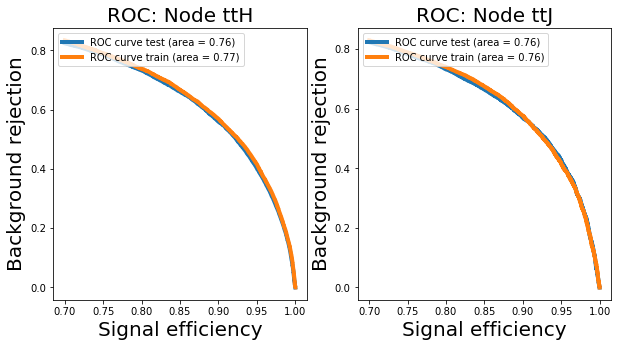

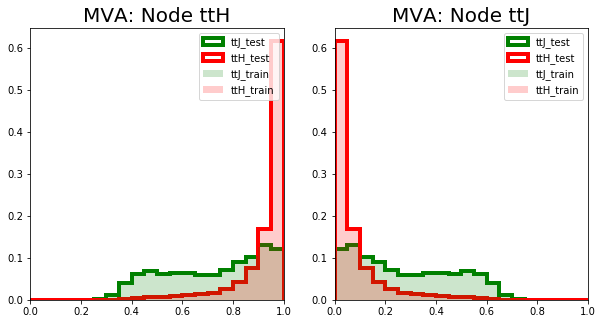

In [5]:
# In[18]:
MakePlots(y_train=Y_train, y_test=Y_test, y_test_pred=result_probs_test, y_train_pred=result_probs, Wt_train=train_weightsROC, Wt_test=test_weightsROC,ROCMask=Conf.ROCMask,keys=Conf.keys,od=Conf.output_directory)
